In [141]:
from numpy import array
from pickle import load
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.utils import plot_model
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import LSTM
from tensorflow.keras.layers import Embedding
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import add
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

import string
from numpy import array
import numpy as np
from os import listdir
from pickle import dump
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.applications.vgg16 import preprocess_input


from numpy import argmax
from nltk.translate.bleu_score import corpus_bleu

In [142]:
# # extract features from each photo in the directory
# def extract_features(directory):
# 	# load the model
# 	model = VGG16()
# 	# re-structure the model
# 	model.layers.pop()
# 	model = Model(inputs=model.inputs, outputs=model.layers[-1].output)
# 	# summarize
# 	print(model.summary())
# 	# extract features from each photo
# 	features = dict()
# 	for name in listdir(directory)[:10]:
# 		# load an image from file
# 		filename = directory + '/' + name
# 		image = load_img(filename, target_size=(224, 224))
# 		# convert the image pixels to a numpy array
# 		image = img_to_array(image)
# 		# reshape data for the model
# 		image = image.reshape((1, image.shape[0], image.shape[1], image.shape[2]))
# 		# prepare the image for the VGG model
# 		image = preprocess_input(image)
# 		# get features
# 		feature = model.predict(image, verbose=0)
# 		# get image id
# 		image_id = name.split('.')[0]
# 		# store feature
# 		features[image_id] = feature
# 		print('>%s' % name)
# 	return features

In [143]:
# # extract features from all images
# directory = 'Flicker8k_Dataset'
# features = extract_features(directory)
# print('Extracted Features: %d' % len(features))

# # save to file
# dump(features, open('features.pkl', 'wb'))

In [144]:
# load doc into memory
def load_doc(filename):
    # open the file as read only
    file = open(filename, 'r')
    # read all text
    text = file.read()
    # close the file
    file.close()
    return text

In [145]:
# load a pre-defined list of photo identifiers
def load_set(filename):
	doc = load_doc(filename)
	dataset = list()
	# process line by line
	for line in doc.split('\n'):
		# skip empty lines
		if len(line) < 1:
			continue
		# get the image identifier
		identifier = line.split('.')[0]
		dataset.append(identifier)
	return set(dataset)

In [146]:
# load photo features
def load_photo_features(filename, dataset):
	# load all features
	all_features = load(open(filename, 'rb'))
	# filter features
	features = {k: all_features[k] for k in dataset}
	return features

In [147]:
# extract descriptions for images
def load_descriptions(doc):
	mapping = dict()
	# process lines
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		if len(line) < 2:
			continue
		# take the first token as the image id, the rest as the description
		image_id, image_desc = tokens[0], tokens[1:]
		# remove filename from image id
		image_id = image_id.split('.')[0]
		# convert description tokens back to string
		image_desc = ' '.join(image_desc)
		# create the list if needed
		if image_id not in mapping:
			mapping[image_id] = list()
		# store description
		mapping[image_id].append(image_desc)
	return mapping

def clean_descriptions(descriptions):
	# prepare translation table for removing punctuation
	table = str.maketrans('', '', string.punctuation)
	for key, desc_list in descriptions.items():
		for i in range(len(desc_list)):
			desc = desc_list[i]
			# tokenize
			desc = desc.split()
			# convert to lower case
			desc = [word.lower() for word in desc]
			# remove punctuation from each token
			desc = [w.translate(table) for w in desc]
			# remove hanging 's' and 'a'
			desc = [word for word in desc if len(word)>1]
			# remove tokens with numbers in them
			desc = [word for word in desc if word.isalpha()]
			# store as string
			desc_list[i] =  ' '.join(desc)

# convert the loaded descriptions into a vocabulary of words
def to_vocabulary(descriptions):
	# build a list of all description strings
	all_desc = set()
	for key in descriptions.keys():
		[all_desc.update(d.split()) for d in descriptions[key]]
	return all_desc

# save descriptions to file, one per line
def save_descriptions(descriptions, filename):
	lines = list()
	for key, desc_list in descriptions.items():
		for desc in desc_list:
			lines.append(key + ' ' + desc)
	data = '\n'.join(lines)
	file = open(filename, 'w')
	file.write(data)
	file.close()


In [178]:
filename="Flicker8k_Text/Flickr8k.token.txt"

In [179]:
# load descriptions
doc = load_doc(filename)
# parse descriptions
descriptions = load_descriptions(doc)
print('Loaded: %d ' % len(descriptions))
# clean descriptions
clean_descriptions(descriptions)
# summarize vocabulary
vocabulary = to_vocabulary(descriptions)
print('Vocabulary Size: %d' % len(vocabulary))
# save to file
save_descriptions(descriptions, 'descriptions.txt')

Loaded: 8092 
Vocabulary Size: 8763


In [180]:
# covert a dictionary of clean descriptions to a list of descriptions
def to_lines(descriptions):
	all_desc = list()
	for key in descriptions.keys():
		[all_desc.append(d) for d in descriptions[key]]
	return all_desc

In [181]:
# load clean descriptions into memory
def load_clean_descriptions(filename, dataset):
	# load document
	doc = load_doc(filename)
	descriptions = dict()
	for line in doc.split('\n'):
		# split line by white space
		tokens = line.split()
		# split id from description
		image_id, image_desc = tokens[0], tokens[1:]
		# skip images not in the set
		if image_id in dataset:
			# create list
			if image_id not in descriptions:
				descriptions[image_id] = list()
			# wrap description in tokens
			desc = 'startseq ' + ' '.join(image_desc) + ' endseq'
			# store
			descriptions[image_id].append(desc)
	return descriptions

In [182]:
# fit a tokenizer given caption descriptions
def create_tokenizer(descriptions):
	lines = to_lines(descriptions)
	tokenizer = Tokenizer()
	tokenizer.fit_on_texts(lines)
	return tokenizer

In [183]:
# calculate the length of the description with the most words
def maxlength(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

In [184]:
# create sequences of images, input sequences and output words for an image
def create_sequences(tokenizer, max_length, desc_list, photo, vocab_size):
#     ins, outs= 0,0
    X1, X2, y = list(), list(), list()
    # walk through each description for the image
    for desc in desc_list:
        # encode the sequence
        seq = tokenizer.texts_to_sequences([desc])[0]
#         print(len(seq))
        # split one sequence into multiple X,y pairs
        for i in range(1, len(seq)):
            # split into input and output pair
            in_seq, out_seq = seq[:i], seq[i]
            # pad input sequence
            in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
            # encode output sequence
            out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
#             ins+=1
#             outs+=1
#             print("In seq", ins, "Out_seq", outs)
            # store
            X1.append(photo)
            X2.append(in_seq)
            y.append(out_seq)
    return array(X1), array(X2), array(y)

In [185]:
# define the captioning model
def define_model(vocab_size, max_length):
	# feature extractor model
	inputs1 = Input(shape=(4096,))
	fe1 = Dropout(0.5)(inputs1)
	fe2 = Dense(256, activation='relu')(fe1)
	# sequence model
	inputs2 = Input(shape=(max_length,))
	se1 = Embedding(vocab_size, 256, mask_zero=True)(inputs2)
	se2 = Dropout(0.5)(se1)
	se3 = LSTM(256)(se2)
	# decoder model
	decoder1 = add([fe2, se3])
	decoder2 = Dense(256, activation='relu')(decoder1)
	outputs = Dense(vocab_size, activation='softmax')(decoder2)
	# tie it together [image, seq] [word]
	model = Model(inputs=[inputs1, inputs2], outputs=outputs)
	# compile model
	model.compile(loss='categorical_crossentropy', optimizer='adam')
	# summarize model
	model.summary()
# 	plot_model(model, to_file='model.png', show_shapes=True)
	return model

In [186]:
# data generator, intended to be used in a call to model.fit_generator()
def data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
#             print(desc_list)
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [[in_img, in_seq], out_word]

In [187]:
# data generator, intended to be used in a call to model.fit_generator()
def train_data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
#             print(desc_list)
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield [in_img, in_seq]
            
# data generator, intended to be used in a call to model.fit_generator()
def val_data_generator(descriptions, photos, tokenizer, max_length, vocab_size):
    # loop for ever over images
    while 1:
        for key, desc_list in descriptions.items():
#             print(desc_list)
            # retrieve the photo feature
            photo = photos[key][0]
            in_img, in_seq, out_word = create_sequences(tokenizer, max_length, desc_list, photo, vocab_size)
            yield out_word

In [188]:
# load training dataset (6K)
filename = 'Flicker8k_text/Flickr_8k.trainImages.txt'
train = load_set(filename)
print('Dataset: %d' % len(train))

Dataset: 6000


In [159]:
train

{'2266061169_dfbf8f0595',
 '1384292980_4022a7520c',
 '374103842_17873ce505',
 '486300784_2cc7a770ff',
 '289616152_012a9f16c6',
 '2326879311_555ebef188',
 '349889354_4b2889a9bd',
 '1685990174_09c4fb7df8',
 '1104133405_c04a00707f',
 '2927878881_90b42fc444',
 '3211577298_14296db6fd',
 '179829865_095b040377',
 '3280644151_3d89cb1e0e',
 '2915183095_4ed4aa4f37',
 '2984704498_29b53df5df',
 '241345639_1556a883b1',
 '3282434895_1c1efc1475',
 '2186087673_c7a73da7ce',
 '2624044128_641b38c0cf',
 '456512643_0aac2fa9ce',
 '2370221025_be4d9a4431',
 '431018958_84b2beebff',
 '557721978_dfde31bc02',
 '241347067_e58d05dbdc',
 '229978782_3c690f5a0e',
 '3638459638_ec74e3ff89',
 '3232030272_b2480a5fe7',
 '3346289227_198fced308',
 '3482237861_605b4f0fd9',
 '1557451043_f5c91ff6f4',
 '3326273086_e09e845185',
 '3662406028_29b9e46a6f',
 '346253487_687150ab04',
 '1752454466_723790dbd6',
 '1449370354_380c4123c9',
 '1526181215_c1a94325ae',
 '3263215700_e27f81f8b9',
 '109260218_fca831f933',
 '2882743431_c3e6cd1b5c',

In [189]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))

Descriptions: train=6000


In [161]:
train_descriptions

{'1305564994_00513f9a5b': ['startseq man in street racer armor be examine the tire of another racer motorbike endseq',
  'startseq two racer drive white bike down road endseq',
  'startseq two motorist be ride along on their vehicle that be oddly design and color endseq',
  'startseq two person be in small race car drive by green hill endseq',
  'startseq two person in race uniform in street car endseq'],
 '1351764581_4d4fb1b40f': ['startseq firefighter extinguish fire under the hood of car endseq',
  'startseq fireman spray water into the hood of small white car on jack endseq',
  'startseq fireman spray inside the open hood of small white car on jack endseq',
  'startseq fireman use firehose on car engine that be up on carjack endseq',
  'startseq firefighter use water to extinguish car that be on fire endseq'],
 '1358089136_976e3d2e30': ['startseq boy sand surf down hill endseq',
  'startseq man be attempt to surf down hill make of sand on sunny day endseq',
  'startseq man be slide

In [190]:
# photo features
train_features = load_photo_features('features_from_colab.pkl', train)
print('Photos: train=%d' % len(train_features))

Photos: train=6000


In [163]:
train_features

{'2266061169_dfbf8f0595': array([[0.        , 0.        , 4.3145924 , ..., 0.        , 0.14392188,
         0.        ]], dtype=float32),
 '1384292980_4022a7520c': array([[0.2701406 , 0.        , 0.        , ..., 0.        , 0.565047  ,
         0.99605733]], dtype=float32),
 '374103842_17873ce505': array([[1.8076516, 1.2397283, 0.       , ..., 0.       , 1.8265939,
         0.       ]], dtype=float32),
 '486300784_2cc7a770ff': array([[0.        , 0.06192857, 0.07115912, ..., 0.        , 1.487894  ,
         0.        ]], dtype=float32),
 '289616152_012a9f16c6': array([[0.70398897, 3.3285756 , 0.        , ..., 0.        , 0.        ,
         0.        ]], dtype=float32),
 '2326879311_555ebef188': array([[0.       , 0.       , 2.735126 , ..., 0.       , 1.6026938,
         0.       ]], dtype=float32),
 '349889354_4b2889a9bd': array([[0.       , 0.       , 0.       , ..., 0.4984181, 2.0811138,
         0.       ]], dtype=float32),
 '1685990174_09c4fb7df8': array([[1.3053985, 0.       , 

In [196]:
# prepare tokenizer
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)

Vocabulary Size: 7579


In [197]:
# determine the maximum sequence length
max_length = maxlength(descriptions)
print('Description Length: %d' % max_length)

Description Length: 32


In [67]:
# define the model
model = define_model(vocab_size, max_length)

Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_8 (InputLayer)            [(None, 18)]         0                                            
__________________________________________________________________________________________________
input_7 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 18, 256)      38144       input_8[0][0]                    
__________________________________________________________________________________________________
dropout (Dropout)               (None, 4096)         0           input_7[0][0]                    
____________________________________________________________________________________________

In [68]:
train_descriptions

{'2926786902_815a99a154': ['startseq skier in yellow jacket be airborne above the mountain endseq',
  'startseq skier jump high in the air with view of the mountain endseq',
  'startseq ski man in fluorescent jacket jump very high and it look as though he be fly endseq',
  'startseq somone be high in the air do ski jump endseq',
  'startseq skier in green jacket and white pants appear to almost fly into the sky endseq'],
 '2513260012_03d33305cf': ['startseq black dog be run after white dog in the snow endseq',
  'startseq black dog chase brown dog through snow endseq',
  'startseq two dog chase each other across the snowy ground endseq',
  'startseq two dog play together in the snow endseq',
  'startseq two dog run through low lie body of water endseq'],
 '2644326817_8f45080b87': ['startseq black and white dog with red frisbee stand on sandy beach endseq',
  'startseq dog drop red disc on beach endseq',
  'startseq dog with red frisbee fly in the air endseq',
  'startseq dog catch red 

In [166]:
def create_sequences_all(tokenizer, max_length, descriptions, photos, vocab_size):
	X1, X2, y = list(), list(), list()
	# walk through each image identifier
	for key, desc_list in descriptions.items():
		# walk through each description for the image
		for desc in desc_list:
			# encode the sequence
			seq = tokenizer.texts_to_sequences([desc])[0]
			# split one sequence into multiple X,y pairs
			for i in range(1, len(seq)):
				# split into input and output pair
				in_seq, out_seq = seq[:i], seq[i]
				# pad input sequence
				in_seq = pad_sequences([in_seq], maxlen=max_length)[0]
				# encode output sequence
				out_seq = to_categorical([out_seq], num_classes=vocab_size)[0]
				# store
				X1.append(photos[key][0])
				X2.append(in_seq)
				y.append(out_seq)
	return array(X1), array(X2), array(y)

In [167]:
# X1train, X2train, ytrain = create_sequences_all(tokenizer, max_length, train_descriptions, train_features, vocab_size)

In [168]:
# ytrain.shape

In [72]:
# # dev dataset

# # load test set
# filename = 'Flicker8k_text/Flickr_8k.devImages.txt'
# test = load_set(filename)
# print('Dataset: %d' % len(test))
# # descriptions
# test_descriptions = load_clean_descriptions('descriptions.txt', test)
# print('Descriptions: test=%d' % len(test_descriptions))
# # photo features
# test_features = load_photo_features('features_from_colab.pkl', test)
# print('Photos: test=%d' % len(test_features))
# # prepare sequences
# X1test, X2test, ytest = create_sequences(tokenizer, max_length, test_descriptions, test_features, vocab_size)

Dataset: 10
Descriptions: test=10
Photos: test=10


In [93]:
# # define checkpoint callback
# filepath = 'model-ep{epoch:03d}-loss{loss:.3f}-val_loss{val_loss:.3f}.h5'
# checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [118]:
# model.fit([X1train, X2train], ytrain, epochs=20,
# #           , callbacks=[checkpoint], validation_data=([X1test, X2test]
# #                                                      , ytest
# )

Train on 516 samples
Epoch 1/20
516/516 [==============================] - 3s 5ms/sample - loss: 0.9249
Epoch 2/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.9228
Epoch 3/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.9008
Epoch 4/20
516/516 [==============================] - 3s 5ms/sample - loss: 0.8520
Epoch 5/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.7401
Epoch 6/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.7213
Epoch 7/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.6261
Epoch 8/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.5992
Epoch 9/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.5450
Epoch 10/20
516/516 [==============================] - 3s 6ms/sample - loss: 0.5139
Epoch 11/20
516/516 [==============================] - 3s 5ms/sample - loss: 0.4790
Epoch 12/20
516/516 [==============================] - 3s 5ms/sa

In [119]:
model.save("toy_model.h5")

In [169]:
generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)

In [294]:
i,j = next(generator)

In [297]:
print(i[0].shape)
print(i[1].shape)
print(j.shape)

(64, 4096)
(64, 18)
(64, 149)


In [298]:
i[0]

array([[1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506],
       [1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506],
       [1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506],
       ...,
       [1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506],
       [1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506],
       [1.0613991, 0.       , 4.225405 , ..., 0.       , 0.       ,
        2.4523506]], dtype=float32)

In [300]:
train_generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
# fit for one epoch
model.fit_generator(train_generator,steps_per_epoch=10, epochs=1)

In [193]:
model = load_model("model_15.h5")

In [198]:
epochs = 22
steps = len(train_descriptions)
for i in range(16,epochs):
	# create the data generator
	generator = data_generator(train_descriptions, train_features, tokenizer, max_length, vocab_size)
	# fit for one epoch
	for j in range(steps):
		(m,n),o = next(generator)
		model.fit((m,n),o, verbose=(j%100==0))
	# save model
	model.save('new_model_' + str(i) + '.h5')
	print("Epoch",i,"completed!")

Train on 47 samples
47/47 [==============================] - 6s 134ms/sample - loss: 3.4171
Train on 61 samples
61/61 [==============================] - 3s 51ms/sample - loss: 3.1171
Train on 52 samples
52/52 [==============================] - 3s 51ms/sample - loss: 3.0743
Train on 55 samples
55/55 [==============================] - 3s 48ms/sample - loss: 3.6242
Train on 45 samples
45/45 [==============================] - 2s 55ms/sample - loss: 3.3702
Train on 35 samples
35/35 [==============================] - 2s 68ms/sample - loss: 2.7150
Train on 70 samples
70/70 [==============================] - 4s 59ms/sample - loss: 3.8059
Train on 37 samples
37/37 [==============================] - 3s 73ms/sample - loss: 3.5099
Train on 54 samples
54/54 [==============================] - 3s 57ms/sample - loss: 3.1809
Train on 54 samples
54/54 [==============================] - 3s 55ms/sample - loss: 3.5465
Train on 48 samples
48/48 [==============================] - 3s 62ms/sample - loss: 3.141

NameError: name 'proj_dir' is not defined

In [199]:
model.save('new_model_' + str(i) + '.h5')

# Evaluating Model

In [135]:
model = load_model("model_15.h5")

In [87]:
from matplotlib.pyplot import imshow

In [88]:
from time import sleep

In [200]:
# map an integer to a word
def word_for_id(integer, tokenizer):
	for word, index in tokenizer.word_index.items():
		if index == integer:
			return word
	return None

# generate a description for an image
def generate_desc(model, tokenizer, photo, max_length):
	# seed the generation process
	in_text = 'startseq'
	# iterate over the whole length of the sequence
	for i in range(max_length):
		# integer encode input sequence
		sequence = tokenizer.texts_to_sequences([in_text])[0]
		# pad input
		sequence = pad_sequences([sequence], maxlen=max_length)
		# predict next word
		yhat = model.predict([photo,sequence], verbose=0)
		# convert probability to integer
		yhat = argmax(yhat)
		# map integer to word
		word = word_for_id(yhat, tokenizer)
		# stop if we cannot map the word
		if word is None:
			break
		# append as input for generating the next word
		in_text += ' ' + word
		# stop if we predict the end of the sequence
		if word == 'endseq':
			break
	return in_text

In [201]:
# evaluate the skill of the model
def evaluate_model(model, descriptions, photos, tokenizer, max_length):
    actual, predicted = list(), list()
    # step over the whole set
    for key, desc_list in descriptions.items():
        # generate description
        yhat = generate_desc(model, tokenizer, photos[key], max_length)

        if key in test:
            imshow(test_images[key].astype(int))
        print(yhat)
        sleep(3)
        # store actual and predicted
        references = [d.split() for d in desc_list]
        actual.append(references)
        predicted.append(yhat.split())

    # calculate BLEU score
    print('BLEU-1: %f' % corpus_bleu(actual, predicted, weights=(1.0, 0, 0, 0)))
    print('BLEU-2: %f' % corpus_bleu(actual, predicted, weights=(0.5, 0.5, 0, 0)))
    print('BLEU-3: %f' % corpus_bleu(actual, predicted, weights=(0.3, 0.3, 0.3, 0)))
    print('BLEU-4: %f' % corpus_bleu(actual, predicted, weights=(0.25, 0.25, 0.25, 0.25)))

In [207]:
# prepare tokenizer on train set
 
# load training dataset (6K)
filename = 'Flicker8k_text/Flickr_8k.trainImages.txt'
train = list(load_set(filename))[0:10]
print('Dataset: %d' % len(train))

Dataset: 10


In [212]:
# descriptions
train_descriptions = load_clean_descriptions('descriptions.txt', train)
print('Descriptions: train=%d' % len(train_descriptions))
# prepare tokenizer

Descriptions: train=10


In [81]:
tokenizer = create_tokenizer(train_descriptions)
vocab_size = len(tokenizer.word_index) + 1
print('Vocabulary Size: %d' % vocab_size)
# determine the maximum sequence length
def max_length(descriptions):
	lines = to_lines(descriptions)
	return max(len(d.split()) for d in lines)

max_length = max_length(train_descriptions)
print('Description Length: %d' % max_length)

Vocabulary Size: 149
Description Length: 18


In [204]:
 
# prepare test set
 
# load test set
filename = 'Flicker8k_text/Flickr_8k.testImages.txt'
test = load_set(filename)
print('Dataset: %d' % len(test))
# descriptions
test_descriptions = load_clean_descriptions('descriptions.txt', test)
print('Descriptions: test=%d' % len(test_descriptions))
# photo features
test_features = load_photo_features('features_from_colab.pkl', test)
print('Photos: test=%d' % len(test_features))

Dataset: 1000
Descriptions: test=1000
Photos: test=1000


In [209]:
test_list = list(test)

In [210]:
test_images = {}
for file in test_list:
    img = load_img("Flicker8k_Dataset/"+file+".jpg")
    img = img_to_array(img)
    test_images[file] = img

KeyboardInterrupt: 

In [123]:
i=0

IndexError: list index out of range

In [213]:
# evaluate model
evaluate_model(model, train_descriptions, train_features, tokenizer, 32)

startseq two children are playing in the water endseq
startseq two girls are playing in the water endseq
startseq man in red shirt is standing on the floor endseq
startseq two people are sitting on the beach endseq
startseq two people are sitting on the beach endseq
startseq two people are sitting on the beach endseq
startseq man in red shirt is standing on the edge of the water endseq
startseq man in red shirt is standing on the beach endseq
startseq two girls are playing in the street endseq
startseq dog is running through the water endseq
BLEU-1: 0.510204
BLEU-2: 0.263767
BLEU-3: 0.184384
BLEU-4: 0.085109


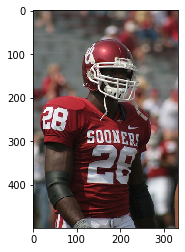

In [85]:
dump(tokenizer, open('toy_tokenizer.pkl', 'wb'))

In [138]:
tokenizer = load(open('tokenizer.pkl', 'rb'))
# pre-define the max sequence length (from training)
max_length = 32

In [86]:
# extract features from each photo in the directory
def extract_features(filename):
    # load the model
    model = VGG16()
    
    # re-structure the model
    model = Model(inputs=model.inputs, outputs=model.layers[-2].output)
#     print(model.summary())
    # load the photo
    image = load_img(filename, target_size=(224, 224))
    # convert the image pixels to a numpy array
    image = img_to_array(image)
#     print(image.shape)
    # reshape data for the model
    image = np.expand_dims(image, axis=0)
#     print(image.shape)
    # prepare the image for the VGG model
    image = preprocess_input(image)
    # get features
    feature = model.predict(image, verbose=0)
    return feature

# load and prepare the photograph
photo = extract_features('dog.jpg')

In [12]:
photo.shape

(1, 4096)

In [13]:
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq dog is running through the grass endseq


In [205]:
photo = extract_features('dog.jpg')

In [206]:
description = generate_desc(model, tokenizer, photo, max_length)
print(description)

startseq dog is running through the snow endseq


In [214]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 32)]         0                                            
__________________________________________________________________________________________________
input_1 (InputLayer)            [(None, 4096)]       0                                            
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 32, 256)      1940224     input_2[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 4096)         0           input_1[0][0]                    
____________________________________________________________________________________________

In [216]:
from tensorflow.keras import models
model = models.Sequential()

In [217]:
from tensorflow.keras import layers

In [218]:
layers.LSTM?

Init signature:
layers.LSTM(
    units,
    activation='tanh',
    recurrent_activation='sigmoid',
    use_bias=True,
    kernel_initializer='glorot_uniform',
    recurrent_initializer='orthogonal',
    bias_initializer='zeros',
    unit_forget_bias=True,
    kernel_regularizer=None,
    recurrent_regularizer=None,
    bias_regularizer=None,
    activity_regularizer=None,
    kernel_constraint=None,
    recurrent_constraint=None,
    bias_constraint=None,
    dropout=0.0,
    recurrent_dropout=0.0,
    implementation=2,
    return_sequences=False,
    return_state=False,
    go_backwards=False,
    stateful=False,
    time_major=False,
    unroll=False,
    **kwargs,
)
Docstring:     
Long Short-Term Memory layer - Hochreiter 1997.

Based on available runtime hardware and constraints, this layer
will choose different implementations (cuDNN-based or pure-TensorFlow)
to maximize the performance. If a GPU is available and all
the arguments to the layer meet the requirement of the CuDNN ke

In [219]:
layers.Embedding?

Init signature:
layers.Embedding(
    input_dim,
    output_dim,
    embeddings_initializer='uniform',
    embeddings_regularizer=None,
    activity_regularizer=None,
    embeddings_constraint=None,
    mask_zero=False,
    input_length=None,
    **kwargs,
)
Docstring:     
Turns positive integers (indexes) into dense vectors of fixed size.

e.g. `[[4], [20]] -> [[0.25, 0.1], [0.6, -0.2]]`

This layer can only be used as the first layer in a model.

Example:

```python
model = Sequential()
model.add(Embedding(1000, 64, input_length=10))
# the model will take as input an integer matrix of size (batch,
# input_length).
# the largest integer (i.e. word index) in the input should be no larger
# than 999 (vocabulary size).
# now model.output_shape == (None, 10, 64), where None is the batch
# dimension.

input_array = np.random.randint(1000, size=(32, 10))

model.compile('rmsprop', 'mse')
output_array = model.predict(input_array)
assert output_array.shape == (32, 10, 64)
```

Arguments:
  in